# Credit Card Fraud Detection

__Goal:__ 

Predict the probability of an online credit card transaction being fraudulent, based on different properties of the transactions. 


## 1. Setup Environment

The goal of this section is to:
- Import all the packages
- Set the options for data visualizations

other dataset: 
https://www.openml.org/search?type=data&status=active&id=45036&sort=runs


In [ ]:
# Data Manipulation
import numpy as np 
import pandas as pd 

# Data Visualization
import seaborn as sns 
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

# Time
import time
import datetime

# Machine Learning
from sklearn.preprocessing import LabelEncoder, minmax_scale
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix , classification_report, accuracy_score, roc_auc_score, plot_roc_curve, precision_recall_curve, plot_precision_recall_curve
from sklearn.calibration import calibration_curve
from sklearn.calibration import CalibratedClassifierCV

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# imbalanced learning (more on this later)
from imblearn.over_sampling import RandomOverSampler
from scipy.stats import chi2_contingency,  f_oneway

import gc
import warnings
from tqdm import tqdm

# Set Options
pd.set_option('display.max_rows', 800)
pd.set_option('display.max_columns', 500)
%matplotlib inline
warnings.filterwarnings("ignore")

Upload the zip file into the left column. Then unzip it;

Good practice to use zip files to speed things up. Also 

In [ ]:
!unzip /content/dataset.parquet.zip

Archive:  /content/dataset.parquet.zip
  inflating: dataset.parquet         
  inflating: __MACOSX/._dataset.parquet  


## 2. Data Overview

Purpose is to:

1. Load the dataset
2. Explore the features

**Note:** Not all transactions have corresponding identity information.

Load the transaction and identity datasets using pd.read_csv(), but for the sake of time, we use pd.read_parquet().

Whenever you have a data file with more than a few thousand rows, don't use pd.read_csv(); too slow and kills progress

In [ ]:
%%time
# Load Data
"""
df = pd.read_csv('/content/creditcard.csv')
df.to_parquet('/content/dataset.parquet') 
"""

# load into the left side with the parquet file 
df = pd.read_parquet('/content/dataset.parquet')
df.head()

CPU times: user 5.39 s, sys: 3.01 s, total: 8.4 s
Wall time: 6.2 s


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,None,None,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,None,None,None,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,None,None,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,None,None,None,None,None,NaN,None,None,None,None,None,None,None,None
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,None,1.0,1.

In [ ]:
# add the parquet file

#df = pd.read_parquet("/content/credit.parquet")

In [ ]:
# Identitiy Data
df.head(10)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,None,None,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,None,None,None,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,None,None,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,None,None,None,None,None,NaN,None,None,None,None,None,None,None,None
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,None,1.0,1.

Shape of data

In [ ]:
print(df.shape)

(590540, 434)


In [ ]:
!pip install pandas_summary

In [ ]:
from pandas_summary import DataFrameSummary


df_summary = DataFrameSummary(df)
df_summary.summary()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
count,590540.0,590540.0,590540.0,590540.0,NaN,590540.0,581607.0,588975.0,NaN,586281.0,NaN,524834.0,524834.0,238269.0,37627.0,NaN,NaN,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,589271.0,309743.0,327662.0,421618.0,280699.0,73187.0,38917.0,74926.0,74926.0,514518.0,311253.0,64717.0,61952.0,62187.0,501427.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,311253.0,311253.0,311253.0,311253.0,311253.0,311253.0,311253.0,311253.0,311253.0,311253.0,311253.0,514467.0,514467.0,514467.0,514467.0,514467.0,514467.0,514467.0,514467.0,514467.0,514467.0,514467.0,514467.0,514467.0,514467.0,514467.0,514467.0,514467.0,514467.0,514467.0,514467.0,514467.0,514467.0,514467.0,421571.0,421571.0,421571.0,421571.0,421571.0,421571.0,421571.0,421571.0,421571.0,421571.0,421571.0,421571.0,421571.0,421571.0,421571.0,421571.0,421571.0,421571.0,513444.0,513444.0,513444.0,513444.0,513444.0,513444.0,513444.0,513444.0,513444.0,513444.0,513444.0,513444.0,513444.0,513444.0,513444.0,513444.0,513444.0,513444.0,513444.0,513444.0,513444.0,513444.0,501376.0,501376.0,501376.0,501376.0,501376.0,501376.0,501376.0,501376.0,501376.0,501376.0,501376.0,501376.0,501376.0,501376.0,501376.0,501376.0,501376.0,501376.0,501376.0,501376.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,81945.0,81945.0,81945.0,81945.0,81945.0,81951.0,81951.0,81951.0,81945.0,81945.0,81945.0,81945.0,81951.0,81951.0,81951.0,81945.0,81945.0,81945.0,81945.0,81945.0,81945.0,81951.0,81951.0,81945.0,81945.0,81945.0,81951.0,81951.0,81951.0,

The above took a real long time! But, it still might be more efficient than writing a for-loop to do things step by step

In [ ]:
# Reduce memory usage
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage(deep=True).sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage(deep=True).sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [ ]:
df = reduce_mem_usage(df)

Mem. usage decreased to 1175.65 Mb (52.7% reduction)


All numeric columns, meaning we don't need to do anything with text data

Get a sense of the distribution of target variable

In [ ]:
df.loc[:, 'isFraud'].value_counts()
# this is to see how many are each class 

0    569877
1     20663
Name: isFraud, dtype: int64

Arrange things more nicely

In [ ]:
class_distrib = pd.DataFrame(df.isFraud.value_counts().reset_index()) # use df["col_name"] or df.col_name to refer to a specific column
# the .reset_index() is needed to make the format nice; otherwise, it's just a mess and columns don't line up
class_distrib.columns = ['class', "count"]
class_distrib

,class,count
0,0,569877
1,1,20663


In [ ]:
# Drop the columns where one category contains more than 90% values
drop_cols = [] # list data structure

# create a for-loop to run through
for col in df.columns: 
    missing_share = df[col].isnull().sum()/df.shape[0]
    if missing_share > 0.9:
        drop_cols.append(col)
        print(col)
        # df[col + "_missing_flag"] = df[col].isnull()
    
good_cols = [col for col in df.columns if col not in drop_cols]

dist2
D7
id_07
id_08
id_18
id_21
id_22
id_23
id_24
id_25
id_26
id_27


An idea: maybe it's good to have some functions in place for future reference. We will define a function now as follows:

In [ ]:
"""
def my_function(param 1, ..., param n):

  # write your function. 
  # Tips: start with some basic structures like lists or dictionaries or some numbers (usually empty or set to 0) 
  # which you will update in a loop or more loops and then return it

  # initalize some variable 
  # (ie) x = 0

  # for i in range(len()) or some_number or df.columns or df.col_name:
    # do something

  # return that variable
"""

In [ ]:
def drop_cols_with_much_missing_values(df):
  drop_cols = [] # list data structure
  # create a for-loop to run through
  for col in df.columns: 
      missing_share = df[col].isnull().sum()/df.shape[0]
      if missing_share > 0.9:
          drop_cols.append(col)
          print(col)
          # df[col + "_missing_flag"] = df[col].isnull()
  good_cols = [col for col in df.columns if col not in drop_cols] # list comprehension [i for i in sth if <condition> else <sth>]
  return good_cols

In [ ]:
good_cols = drop_cols_with_much_missing_values(df)
print(f"here are the good_cols: {good_cols}")

dist2
D7
id_07
id_08
id_18
id_21
id_22
id_23
id_24
id_25
id_26
id_27
here are the good_cols: ['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'dist1', 'P_emaildomain', 'R_emaildomain', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70', '

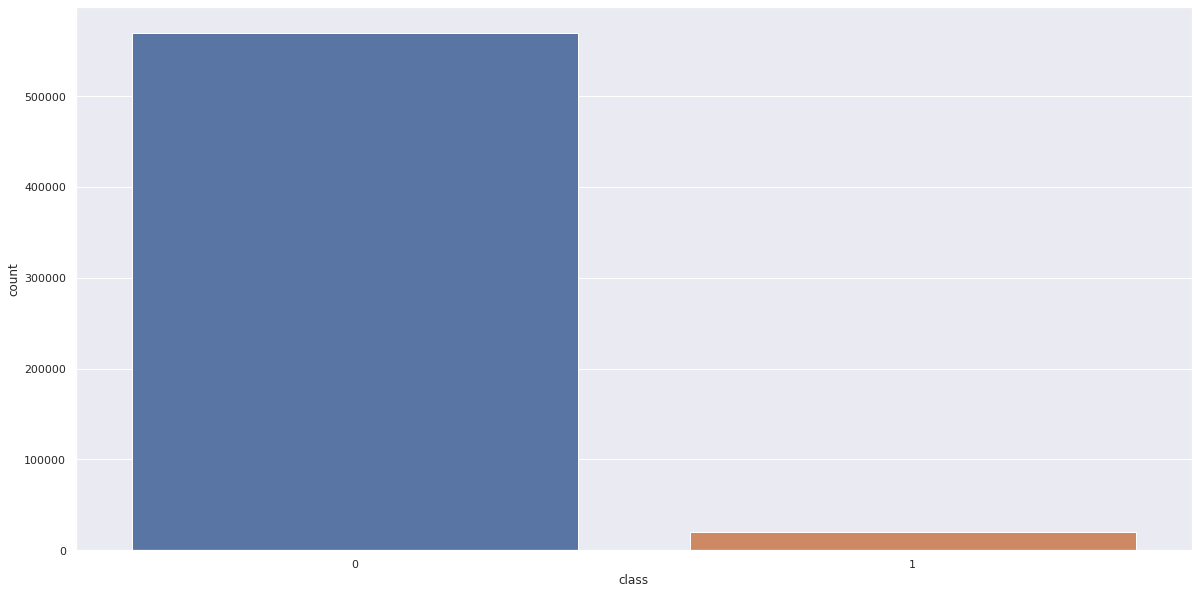

In [ ]:
sns.set(rc={"figure.figsize":(20, 10)}) # set the figure size to make things look bigger.
sns.barplot(data=class_distrib, x="class", y="count")

This dataset has a big imbalance issue. This will be an issue moving forward, we want to be careful about which metircs to use to evaluate our machine learning model 

In [ ]:
pd.DataFrame(df.TransactionDT.value_counts().reset_index())

,index,TransactionDT
0,9474817,8
1,11576951,5
2,4397066,5
3,7236588,5
4,1544629,4
...,...,...
573344,4629634,1
573345,4629631,1
573346,4629557,1
573347,4629466,1


we do have a datetime column and we need to process it

In [ ]:
from datetime import datetime, timedelta

In [ ]:
# Date features

START_DATE         = '2017-12-01' 
# given that the start date is from this date forward. From above, the 8, 5, ..., 1 are 
startdate          = datetime.strptime(START_DATE, "%Y-%m-%d")
df["Date"]         = df['TransactionDT'].apply(lambda x: (startdate + timedelta(seconds=x)))

df['_Weekdays']    = df['Date'].dt.dayofweek
df['_Hours']       = df['Date'].dt.hour
df['_Days']        = df['Date'].dt.day

In [ ]:
df._Days.value_counts()

3     24197
4     23223
2     21894
23    21265
24    21026
21    20358
5     20200
6     20095
20    19914
22    19675
13    19625
17    19617
25    19606
26    19563
19    19089
10    19074
14    19049
16    18839
9     18788
15    18784
7     18742
1     18264
18    18158
8     18117
12    17989
27    17946
11    17879
28    17662
30    15361
29    13379
31    13162
Name: _Days, dtype: int64

In [ ]:
df.P_emaildomain.value_counts()

Google            228851
Yahoo Mail        102909
NoInf              94456
Microsoft          59477
anonymous.com      36998
aol.com            28289
comcast.net         7888
icloud.com          6267
Others              4913
att.net             4033
sbcglobal.net       2970
verizon.net         2705
ymail.com           2396
bellsouth.net       1909
me.com              1522
cox.net             1393
optonline.net       1011
charter.net          816
rocketmail.com       664
mail.com             559
earthlink.net        514
Name: P_emaildomain, dtype: int64

In [ ]:
df.loc[df['P_emaildomain'].isin(['gmail.com', 'gmail']),'P_emaildomain'] = 'Google'

df.loc[df['P_emaildomain'].isin(['yahoo.com', 'yahoo.com.mx',  'yahoo.co.uk',
                                         'yahoo.co.jp', 'yahoo.de', 'yahoo.fr',
                                         'yahoo.es']), 'P_emaildomain'] = 'Yahoo Mail'

df.loc[df['P_emaildomain'].isin(['hotmail.com','outlook.com','msn.com', 'live.com.mx', 
                                         'hotmail.es','hotmail.co.uk', 'hotmail.de',
                                         'outlook.es', 'live.com', 'live.fr',
                                         'hotmail.fr']), 'P_emaildomain'] = 'Microsoft'

df.loc[df.P_emaildomain.isin(df.P_emaildomain\
                                         .value_counts()[df.P_emaildomain.value_counts() <= 500 ]\
                                         .index), 'P_emaildomain'] = "Others"
                                         
df.P_emaildomain.fillna("NoInf", inplace=True)

In [ ]:
# Average fraud per transaction by Product CD

df.groupby('ProductCD')['isFraud'].mean()

ProductCD
C    0.116873
H    0.047662
R    0.037826
S    0.058996
W    0.020399
Name: isFraud, dtype: float64

In [ ]:
# Average fraud per transaction by email domain

df.groupby('P_emaildomain')['isFraud'].mean()

P_emaildomain
aim.com             0.126984
anonymous.com       0.023217
aol.com             0.021811
att.net             0.007439
bellsouth.net       0.027763
cableone.net        0.018868
centurylink.net     0.000000
cfl.rr.com          0.000000
charter.net         0.030637
comcast.net         0.031187
cox.net             0.020818
earthlink.net       0.021401
embarqmail.com      0.034615
frontier.com        0.028571
frontiernet.net     0.025641
gmail               0.022177
gmail.com           0.043542
gmx.de              0.000000
hotmail.co.uk       0.000000
hotmail.com         0.052950
hotmail.de          0.000000
hotmail.es          0.065574
hotmail.fr          0.000000
icloud.com          0.031434
juno.com            0.018634
live.com            0.027622
live.com.mx         0.054740
live.fr             0.000000
mac.com             0.032110
mail.com            0.189624
me.com              0.017740
msn.com             0.021994
netzero.com         0.000000
netzero.net         0.005102


## EDA (visualizations)

### Barplots

In [47]:
def plot_cat_with_amt(df, col, lim=2000):
    tmp = pd.crosstab(df[col], df['isFraud'], normalize='index') * 100
    tmp = tmp.reset_index()
    tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)
    
    plt.figure(figsize=(16,14))    
    plt.suptitle(f'{col} Distributions ', fontsize=24)
    
    plt.subplot(211)
    g = sns.countplot( x=col,  data=df, order=list(tmp[col].values))

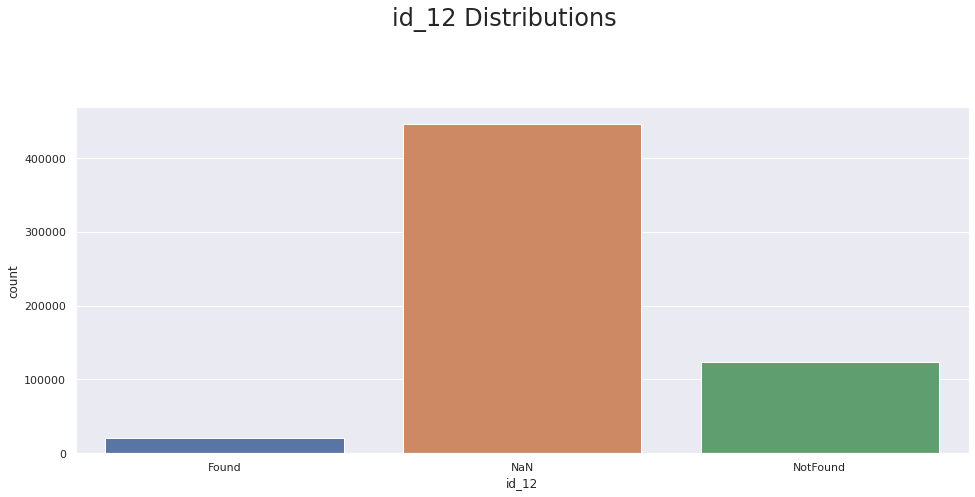

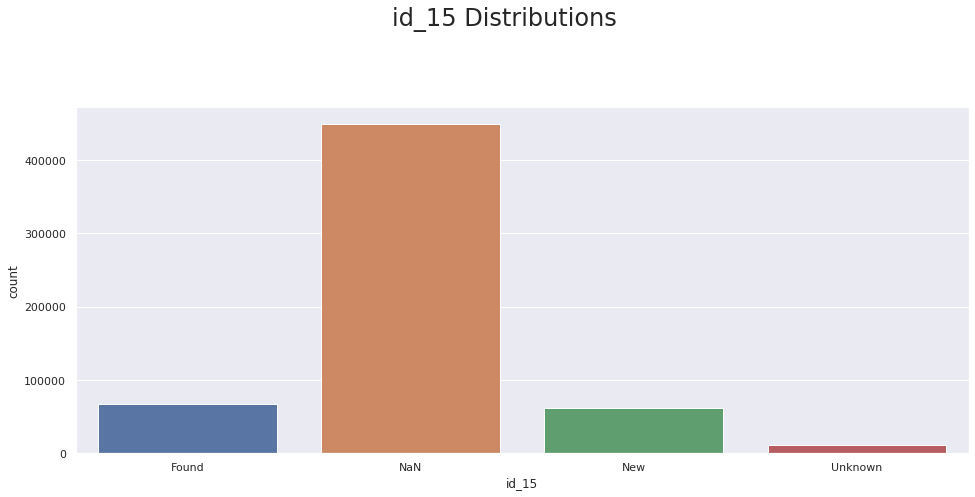

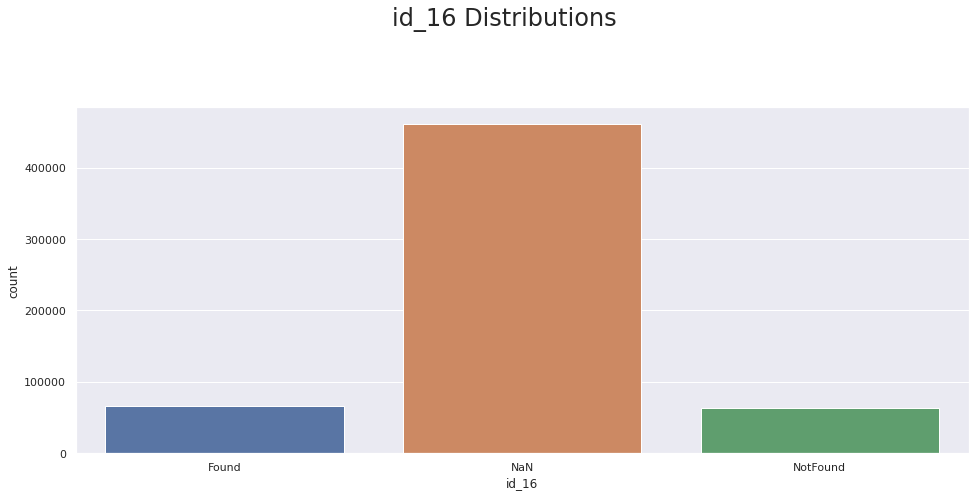

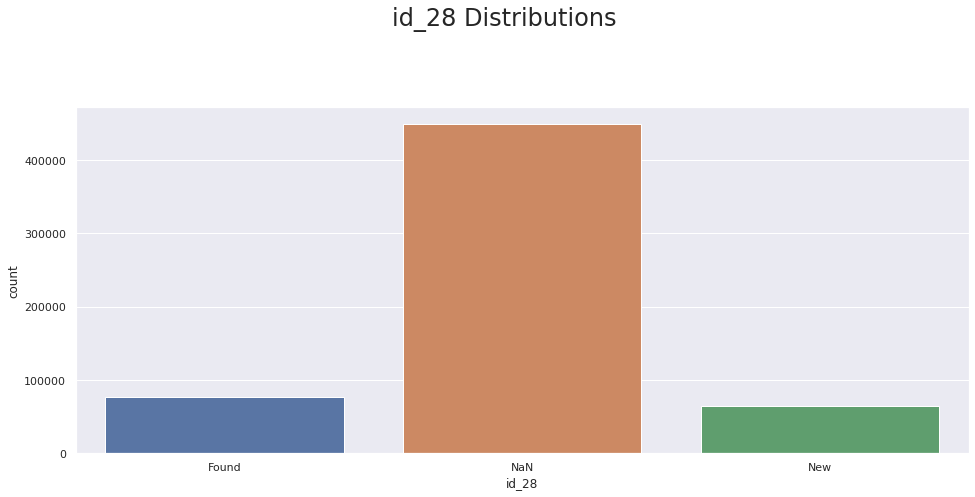

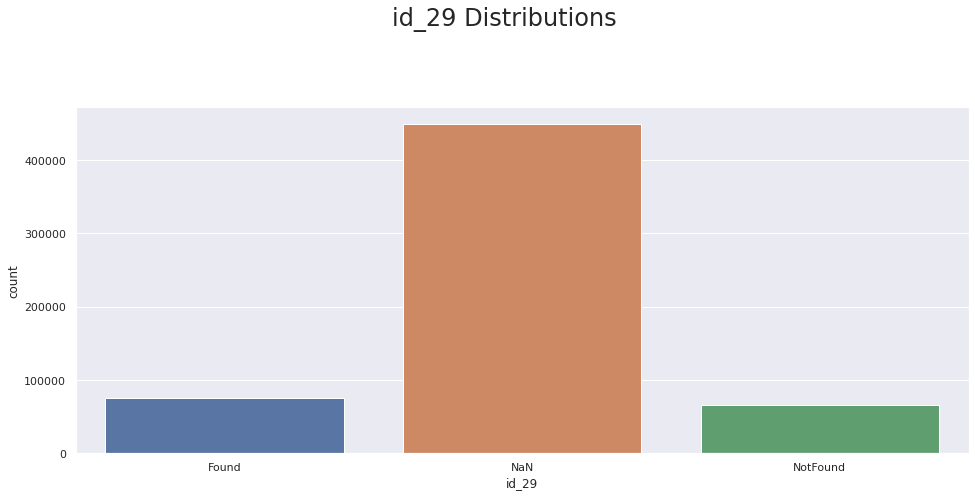

In [48]:
for col in ['id_12', 'id_15', 'id_16', 'id_28', 'id_29']:
    df[col] = df[col].fillna('NaN') # or do df[col].fillna('NaN', inplace=True)
    plot_cat_with_amt(df, col)

In [ ]:
print(list(df.columns))

['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V75', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 'V

Do the same for the C, D, M, V-variables, ids, etc

### Distribution

Text(0, 0.5, 'Probability')

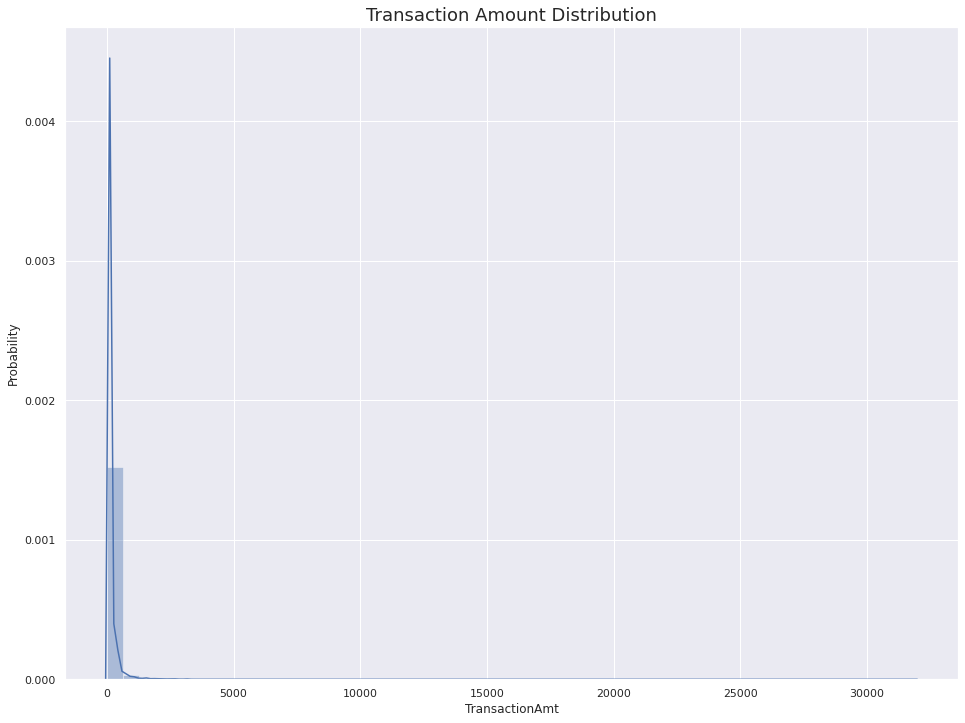

In [ ]:
# Distribution plot of Transaction Amount
plt.figure(figsize=(16,12))

sns.distplot(df['TransactionAmt'])
plt.title("Transaction Amount Distribution", fontsize=18)
plt.ylabel("Probability")

Heavily skewed to the right: not anything close to a normal distribution at all

Let's narrow down further:
See the distribute of the lower values (restrict to a narrower range)

Text(0, 0.5, 'Probability')

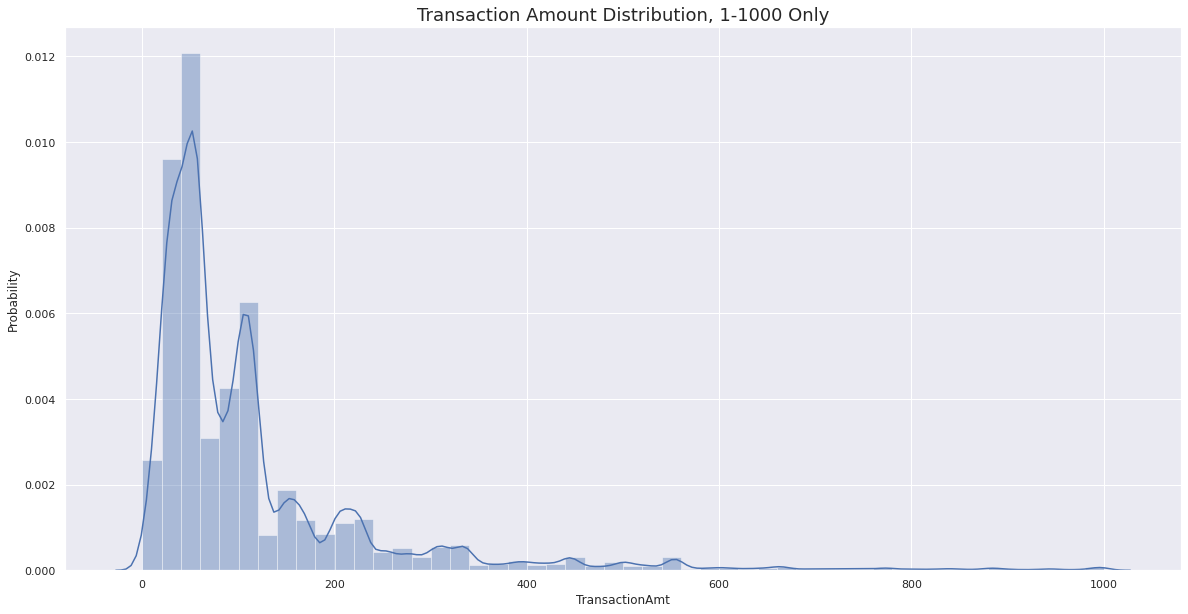

In [ ]:
# sns.distplot(df['TransactionAmt'])
sns.set(rc={"figure.figsize":(20, 10)}) # set the figure size to make things look bigger.
sns.distplot(df[df['TransactionAmt'] <= 1000]['TransactionAmt'])
plt.title("Transaction Amount Distribution, 1-1000 Only", fontsize=18)
plt.ylabel("Probability")

In [ ]:
sns.boxplot(
    data=df,
    x='Survived',
    y='Age',
    hue="Sex")

We can find the log of the TransactionAmt column to make it distribution appear more centered and more like normal distribution. Could also try np.sqrt()

Some models are very sensitive to distribution of data. 

Text(0, 0.5, 'Probability')

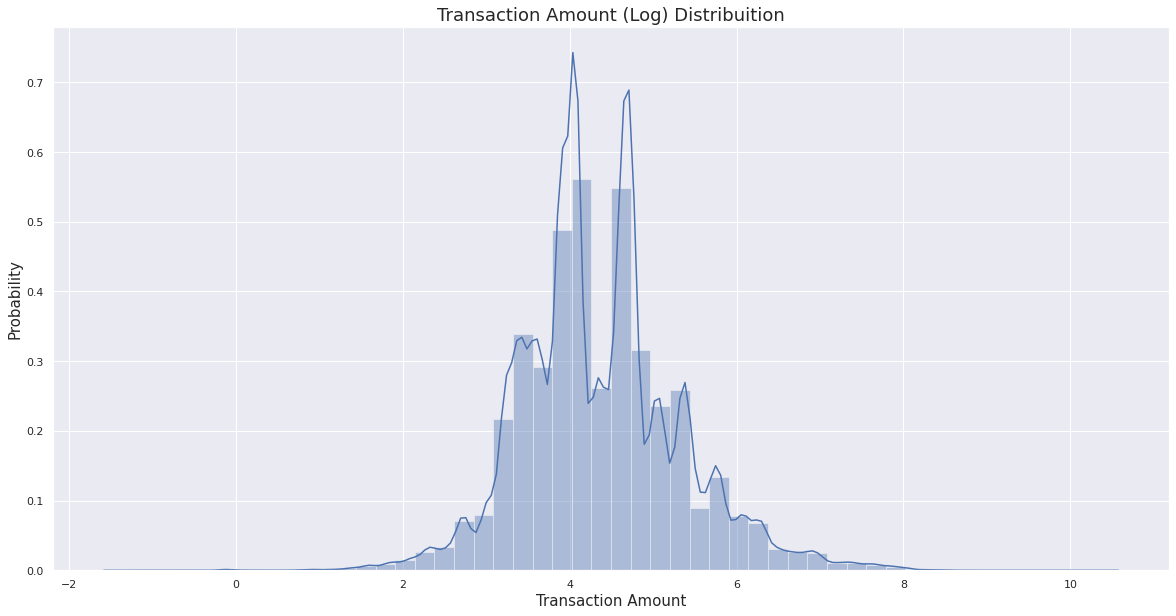

In [ ]:
sns.distplot(np.log(df['TransactionAmt']))
plt.title("Transaction Amount (Log) Distribuition", fontsize=18)
plt.xlabel("Transaction Amount", fontsize=15)
plt.ylabel("Probability", fontsize=15)

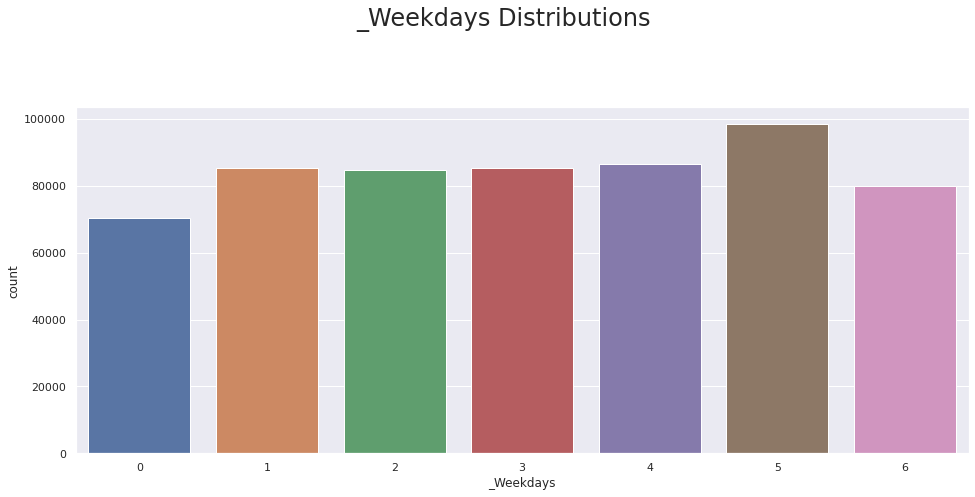

In [49]:
plot_cat_with_amt(df, '_Weekdays')

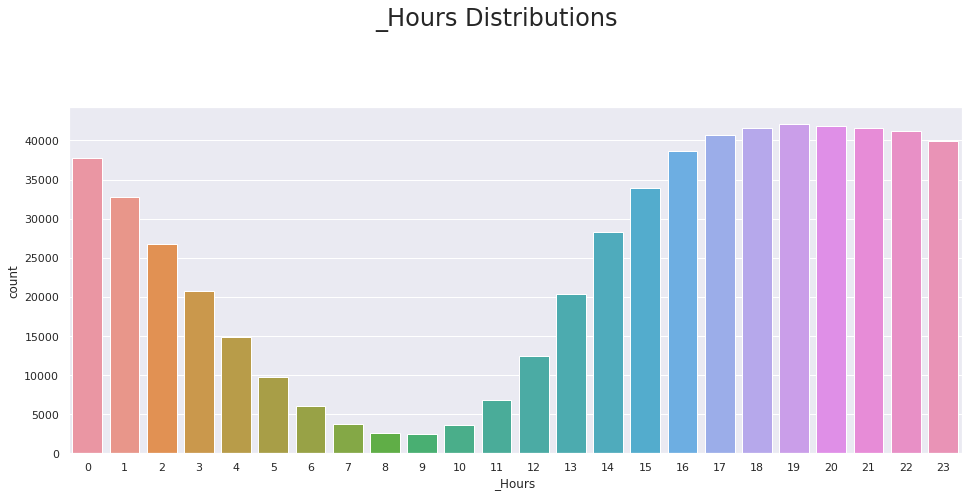

In [50]:
plot_cat_with_amt(df, '_Hours')

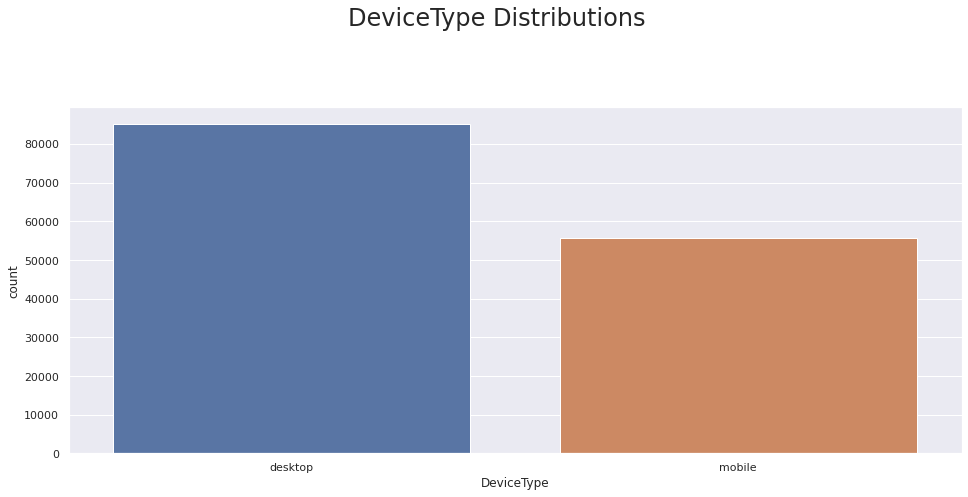

In [52]:
plot_cat_with_amt(df, 'DeviceType')

### Significance Tests

Chi-Squared Test

Chi-Square test tells if the entire variable is useful or not.

In [ ]:
cat_columns = df.select_dtypes(include=['object']).columns
len(cat_columns)

binary_columns = [col for col in df.columns if df[col].nunique() == 2]
len(binary_columns)

num_columns = [col for col in df.columns if (col not in cat_columns) & (col not in binary_columns)]
len(num_columns)

399

In [41]:
print(f"Number of columns \n\ncategorical: {len(cat_columns)}\nbinary: {len(binary_columns)} \nnumerical: {len(num_columns)}")

Number of columns 

categorical: 31
binary: 26 
numerical: 399


In [ ]:
from scipy.stats import chi2_contingency

In [ ]:
# significance value
alpha = 0.05

significant_categorical_variables = []

for col in cat_columns:  
    # Create a crosstab table
    temp = pd.crosstab(df[col],df['isFraud'].astype('category'))
    
    # Get chi-square value , p-value, degrees of freedom, expected frequencies using the function chi2_contingency
    stat, p, dof, expected = chi2_contingency(temp)
    
    # Determine whether to reject or keep your null hypothesis
    print(col.ljust(40), ',  chisquared=%.5f,   p-value=%.5f' % (stat, p))
    if p <= alpha:
        significant_categorical_variables.append(col)
    else:
        continue

ProductCD                                ,  chisquared=16742.17153,   p-value=0.00000
card4                                    ,  chisquared=364.87414,   p-value=0.00000
card6                                    ,  chisquared=5957.03229,   p-value=0.00000
P_emaildomain                            ,  chisquared=3497.81283,   p-value=0.00000
R_emaildomain                            ,  chisquared=3670.55207,   p-value=0.00000
M1                                       ,  chisquared=0.00000,   p-value=1.00000
M2                                       ,  chisquared=438.61321,   p-value=0.00000
M3                                       ,  chisquared=477.66057,   p-value=0.00000
M4                                       ,  chisquared=6450.44798,   p-value=0.00000
M5                                       ,  chisquared=242.42169,   p-value=0.00000
M6                                       ,  chisquared=227.96414,   p-value=0.00000
M7                                       ,  chisquared=11.25610,   p-val

In [44]:
ctab = pd.crosstab(df['ProductCD'], df['isFraud'].astype('category'))
ctab

isFraud,0,1
ProductCD,,
C,60511,8008
H,31450,1574
R,36273,1426
S,10942,686
W,430701,8969


In [45]:
ctab.columns = ctab.columns.add_categories('odds')
ctab['odds'] = ctab[1]/ctab[0]
ctab

isFraud,0,1,odds
ProductCD,,,
C,60511,8008,0.132340
H,31450,1574,0.050048
R,36273,1426,0.039313
S,10942,686,0.062694
W,430701,8969,0.020824


In [46]:
ctab.columns = ctab.columns.add_categories('odds_ratio')
ctab['odds_ratio'] = ctab['odds'] / (ctab[1].sum()/ctab[0].sum())
ctab

isFraud,0,1,odds,odds_ratio
ProductCD,,,,
C,60511,8008,0.132340,3.649871
H,31450,1574,0.050048,1.380295
R,36273,1426,0.039313,1.084236
S,10942,686,0.062694,1.729080
W,430701,8969,0.020824,0.574323


Highers odds ratio implies more chance of fraud in that category.

Farther away it is from 1.0 (both directions) more important the variable is.